https://towardsdatascience.com/streamline-model-tuning-on-bankruptcy-predictions-aabbc2fe62c0

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Load up packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import GradientBoostingClassifier
#from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
#import h2o
#from h2o.automl import H2OAutoML


In [2]:
from xgboost import XGBClassifier

In [3]:
# Load data
data = pd.read_csv('/Users/reejungkim/Documents/Git/companies-bankruptcy-forecast/bankruptcy_Train.csv')

In [4]:
data.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,-0.031545,-0.091313,-0.040269,-0.013529,0.007406,-0.016047,-0.000264,0.641242,-0.748385,0.126789,...,0.014367,0.005457,-0.014143,-0.020924,0.068399,-0.214478,-0.013915,-0.173939,-0.046788,0
1,-0.231729,-0.049448,0.304381,-0.080975,0.007515,-0.016047,-0.034963,0.074710,0.469815,0.073759,...,0.008492,-0.008385,-0.008666,-0.023095,-0.033498,-0.205796,-0.015174,-0.073056,-0.027236,0
2,-0.058602,0.065060,-0.488404,-0.189489,0.006572,-0.016047,-0.004954,-0.456287,0.270351,-0.071287,...,0.010819,0.006779,-0.009437,-0.007919,-0.043455,0.019740,-0.011736,-0.291624,-0.033580,0
3,-0.069376,0.044641,-0.181684,-0.140032,0.007477,-0.010915,-0.005599,-0.462971,-0.286746,-0.085266,...,0.010683,0.005384,-0.010840,0.001381,-0.042828,-0.350519,0.002969,-0.554685,-0.046823,0
4,0.236424,-0.051912,0.678337,-0.014680,0.007879,-0.016047,0.057418,0.097183,0.423405,0.076880,...,0.010970,0.025295,-0.011056,-0.022535,-0.035892,-0.181557,-0.015623,-0.027841,-0.023694,0


In [5]:
data['class'].unique()

array([0, 1])

In [6]:
# Checking for null values
data.isnull().values.any()


False

In [7]:
data.rename(columns={'class':'target'}, inplace=True)

In [8]:
# For features in h2o model
cont_names = data.columns[:-1]
#Setting up desired output and features for logistic regression and xgboost models
output = data[data.columns[-1]]
features = data[data.columns[:(data.shape[1]-1)]]

In [9]:
#splits data into X (features) and y (predictions)
X_train, X_test, y_train, y_test = train_test_split(features, output, test_size=0.2, random_state=42)
train = pd.concat([X_train, y_train], 1)
test = pd.concat([X_test, y_test], 1)

In [10]:
plt.figure()
# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(class_weight='balanced'),
},
{
    'label': 'XGBoost Classifier',
    'model': XGBClassifier(max_depth=10, n_estimators=300, use_label_encoder=False),
  # 'model': GradientBoostingClassifier(n_estimators=300,max_depth=10)
}
]

<Figure size 432x288 with 0 Axes>

In [11]:
# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train, y_train) # train the model
    y_pred=model.predict(X_test) # predict the test data

[21:22:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


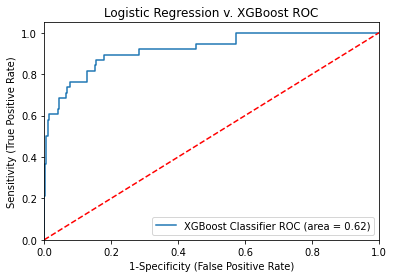

In [12]:
# Compute False postive rate, and True positive rate
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

# Calculate Area under the curve to display on the plot
auc = roc_auc_score(y_test,model.predict(X_test))

# Now, plot the computed values
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))

# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('Logistic Regression v. XGBoost ROC')
plt.legend(loc="lower right")
plt.show()

In [13]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=1, random_state=0)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.98

In [14]:
y_predict = clf.predict(X_test)

In [15]:
y_predict

array([0, 0, 0, ..., 0, 0, 0])

In [16]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_predict)**(0.5)

0.1414213562373095

In [17]:
import shap


explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)

In [18]:
shap_values

array([[ 0.03785839, -0.13097837,  0.        , ..., -0.05304892,
         0.        ,  0.02831878],
       [ 0.03785839,  0.25905858,  0.        , ...,  0.69280579,
         0.        ,  0.02831878],
       [ 0.03785839,  0.25905858,  0.        , ..., -0.05304892,
         0.        ,  0.02831878],
       ...,
       [ 0.03785839,  0.25905858,  0.        , ..., -0.05304892,
         0.        ,  0.02831878],
       [ 0.03785839,  0.25905858,  0.        , ..., -0.05304892,
         0.        ,  0.02831878],
       [ 0.03785839, -0.13097837,  0.        , ..., -0.05304892,
         0.        ,  0.02831878]])

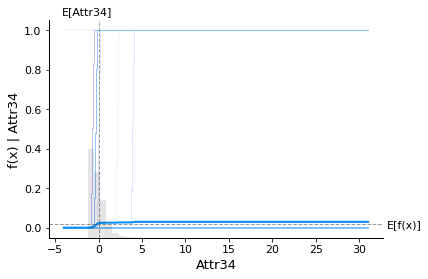

In [29]:
shap.partial_dependence_plot("Attr34", 
                             model.predict, X_train,
                             model_expected_value=True, 
                             feature_expected_value=True)

shap.plots.partial_dependence("Attr34", 
                             model.predict, X_train,
                             model_expected_value=True, 
                             feature_expected_value=True)

#the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.waterfall_plot(explainer.expected_value, 
                    shap_values[sample_ind], 
                    X.iloc[sample_ind], 
                    max_display=14)

shap.force_plot(explainer.expected_value, 
                shap_values, 
                features=X_train, 
                feature_names=X_train.columns)

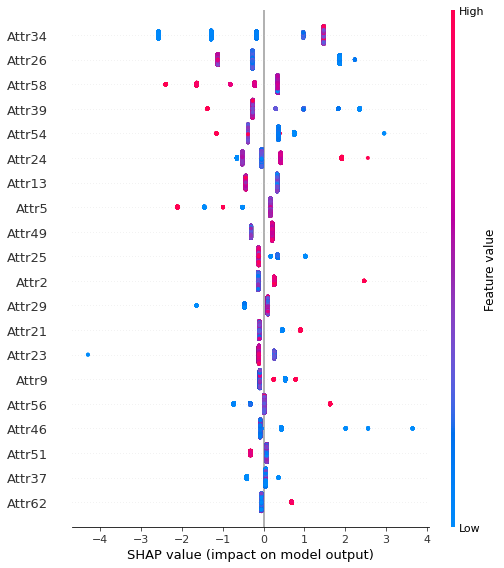

In [19]:
shap.summary_plot(shap_values, 
                  features=X_train, 
                  feature_names=X_train.columns)

shap.summary_plot(shap_values, 
                  features=X_train, plot_type='dot', 
                  max_display=X_train.columns.shape[0],
                  feature_names=X_train.columns)